In [2]:
from ColumnTransformers import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC
import json
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import roc_curve, auc, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


Funkcje do strojenia hiperparametrów, opierają się na GridSearchach (poza RandomForest, w którym jest RandomizedSearch, bo tu jest zbyt mała efektywność czasowa [po 17 godzinach działania GridSearcha dalej nie było wyników]).

Zapisują najlepsze parametry w pliku JSON

Niektóre modele był strojone dwukrotnie, niektóre tylko raz (chcieliśmy dożyć wyników).

In [3]:
def KNNSearch(df_X,y,metric='recall') : 
    param_grid = {
        # 'n_neighbors' : np.arange(1,20,3), # strojenie 1
        #         'weights' : ['uniform', 'distance']
        'n_neighbors' : np.arange(1,5,1), # strojenie 2
        'weights' : ['uniform']

    }
    transformer=PipeLineColumnTransformer() 
    transformer.fit(df_X,y) 
    X=transformer.transform(df_X) 
    model= KNeighborsClassifier(n_jobs=-1)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=metric, n_jobs=-1)
    grid_search.fit(X,y)
    best_params=grid_search.best_params_
    print(best_params)
    with open("savedModels/KNN.json", "w") as f:
        json.dump(best_params, f, indent=4)
    return best_params

def LogRegSearch(df_X,y,metric='recall') : 
    param_grid = {
        # 'C' : [1e-5, 1e-3, 1e-1, 1, 100, 1000], # strojenie 1
        # 'class_weight' : ['balanced', {0:1,1:2}, {0:1,1:4}, {0:1,1:7}, {0:1,1:10}]
        'C' : [1e-5, 5e-4, 1e-4, 5e-3, 1e-3], # strojenie 2
        'class_weight' : ['balanced'],
        'penalty' : ['l1', 'l2']
    }
    transformer=PipeLineColumnTransformer() 
    transformer.fit(df_X,y) 
    X=transformer.transform(df_X) 
    model= LogisticRegression(penalty='l1', solver = 'saga', n_jobs=-1, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=metric, n_jobs=-1)
    grid_search.fit(X,y)
    best_params=grid_search.best_params_
    with open("savedModels/LogisticRegression.json", "w") as f:
        json.dump(best_params, f, indent=4)
    return best_params

def SVMSearch(df_X,y,metric='recall') : 
    param_grid = {
            'C': [1e-5, 1e-3, 1e-1, 1, 10, 100],
            'max_iter': [1000, 5000, 10000],
            'tol': [1e-3, 1e-5],
            'penalty': ['l2', 'l1'],
            'class_weight' : ['balanced', {0:1,1:2}, {0:1,1:4}, {0:1,1:7}, {0:1,1:10}]
    }
    
    ######
    Numerical=['Transaction.Amount', 'Customer.Age','Account.Age.Days','Quantity']
    CatBasic=["Payment.Method",'browser','Product.Category','Device.Used','source']
    column_transformer=PipeLineColumnTransformer(Numerical,CatBasic)
    log_clf = LogisticRegression(C=0.1, class_weight="balanced",  penalty='l1', 
    solver='liblinear', random_state=42)
    selector = RFE(estimator=log_clf, n_features_to_select=10, step=1) # mniej feature'ów, żeby SVM się kiedyś doliczył
    transformer=Pipeline([
    ('preprocessor', column_transformer),  
    #('smote', SMOTE(sampling_strategy=0.1,random_state=42)), ## TO DISCUSS
    ('featureselection',selector)
     ])
    ######
    
    transformer.fit(df_X,y) 
    X=transformer.transform(df_X) 
    model= LinearSVC(random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=metric, n_jobs=-1)
    grid_search.fit(X,y)
    best_params=grid_search.best_params_
    with open("savedModels/SVM.json", "w") as f:
        json.dump(best_params, f, indent=4)
    return best_params

def DecisionTreeSearch(df_X,y,metric='recall') : 
    param_grid = {
    #     'max_depth': [2, 5, 10, 15], # strojenie 1
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [2, 5, 10],
    # 'max_features': ['sqrt', 'log2', 0.2, 0.5, 0.8],
    # 'max_leaf_nodes': [10, 20, 50],
    # 'class_weight' : ['balanced', {0:1,1:2}, {0:1,1:4}, {0:1,1:7}, {0:1,1:10}]
    'max_depth': [8,9,10,11,12], # strojenie 2
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3],
    'max_features': [0.4, 0.45, 0.5, 0.55, 0.6, 0.65],
    'max_leaf_nodes': [10, 20, 30, 35, 40, 45, 50, 55, 60, 65],
    'class_weight' : ['balanced']
    }
    transformer=PipeLineColumnTransformer() 
    transformer.fit(df_X,y) 
    X=transformer.transform(df_X) 
    model= DecisionTreeClassifier(random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=metric, n_jobs=-1)
    grid_search.fit(X,y)
    best_params=grid_search.best_params_
    with open("savedModels/DecisionTree.json", "w") as f:
        json.dump(best_params, f, indent=4)
    return best_params

def RandomForestSearch(df_X,y,metric='recall') : 
    param_grid = {'n_estimators': [50, 200],
    'max_depth': [2, 5, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2', 0.2, 0.5, 0.8],
    'class_weight' : ['balanced', {0:1,1:2}, {0:1,1:4}, {0:1,1:7}]
    }
    transformer=PipeLineColumnTransformer() 
    transformer.fit(df_X,y) 
    X=transformer.transform(df_X) 
    model= RandomForestClassifier(random_state=42)
    grid_search = RandomizedSearchCV(model, param_grid, cv=5, n_iter = 100, scoring=metric, n_jobs=-1)
    grid_search.fit(X,y)
    best_params=grid_search.best_params_
    with open("savedModels/RandomForest.json", "w") as f:
        json.dump(best_params, f, indent=4)
    return best_params

def NaiveBayesSearch(df_X,y,metric='recall') : 
    param_grid = {
    #     'alpha': [0.01, 0.1, 1.0, 10.0], # strojenie 1
    # 'fit_prior': [True, False],
    # 'min_categories': [2, 5]
    'alpha': [8.0, 9.0, 10.0, 11.0, 20], # strojenie 2
    'fit_prior': [False],
    'min_categories': [2,3,4]
    }
    transformer=PipeLineColumnTransformer(NB=True) 
    transformer.fit(df_X,y) 
    X=transformer.transform(df_X) 
    model= CategoricalNB()
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=metric, n_jobs=-1)
    grid_search.fit(X,y)
    best_params=grid_search.best_params_
    with open("savedModels/CategoricalNB.json", "w") as f:
        json.dump(best_params, f, indent=4)
    return best_params

Obsługa znalezionych (tymczasowo) najlepiej sparametryzowanych modeli, prosta analiza wyników

In [4]:
def ReadCreatedModel(modelName): 
    with open(f"savedModels/{modelName}.json", "r") as f:
        best_params=json.load(f) 
    if modelName == "KNN":
        model = KNeighborsClassifier(n_jobs=-1, **best_params)
    elif modelName == "LogisticRegression":
        model = LogisticRegression(solver = 'saga', n_jobs=-1, random_state=42, **best_params)
    elif modelName == "SVM":
        model = LinearSVC(random_state=42, **best_params)
    elif modelName == "DecisionTree":
        model = DecisionTreeClassifier(random_state=42, **best_params)
    elif modelName == "RandomForest":
        if best_params['class_weight'] != 'balanced':
            best_params['class_weight'] = dict([(0,1),(1,best_params['class_weight']["1"])])
        model = RandomForestClassifier(random_state=42, **best_params)
    elif modelName == "CategoricalNB":
        model = CategoricalNB(**best_params)
    return model
    
def TestingModel(modelName, X_train, X_test, y_train, y_test, threshold = 0.5):
    
    Model = ReadCreatedModel(modelName) 
    Model = PipelineModel(Model)
    Model.fit(X_train, y_train)
    
    if modelName == "SVM":
        y_scores = Model.decision_function(X_test) 
    else:
        y_scores = Model.predict_proba(X_test)[:, 1] 

    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    aucPlot(fpr, tpr, roc_auc)

    y_pred = (np.array(y_scores) > threshold).astype(int)
    PredictionQualityInfo(y_pred, y_test)
    print(f"AUC: {roc_auc}, Recall: {recall_score(y_test, y_pred)}")
    return Model


def aucPlot(fpr, tpr, roc_auc):    
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.legend(loc="lower right")
    plt.show()


In [5]:
X_train, y_train = getTrainingData()
X_test, y_test = getTestData()

Nie uruchamiać, bo Was zmiecie z planszy - to jest to całe strojenie

In [6]:
# try:
#     KNNSearch(X_train,y_train)

# except Exception as e:
#     print("Something is no yes with KNN")
#     print(e)
# try:
#     NaiveBayesSearch(X_train,y_train)

# except Exception as e:
#     print("Something is no yes with Naive Bayes")
#     print(e)
# try:
#     DecisionTreeSearch(X_train,y_train)

# except Exception as e:
#     print("Something is no yes with DecisionTree")
#     print(e)
# try:
#     LogRegSearch(X_train,y_train, metric = 'f1') # z domyślną metryką recall algorytm ma tendecję do całkowitego odrzucania nie-fraudów sztucznie zawyżając recall

# except Exception as e:
#     print("Something is no yes with LogReg")
#     print(e)
# try:
#     SVMSearch(X_train,y_train)
# except Exception as e:
#     print("Something is no yes with SVM")
#     print(e)
# try:
#     RandomForestSearch(X_train,y_train)
# except Exception as e:
#     print("Something is no yes with RandomForest")
#     print(e)

# Po strojeniach

### KNN - niska efektywność wykrywania

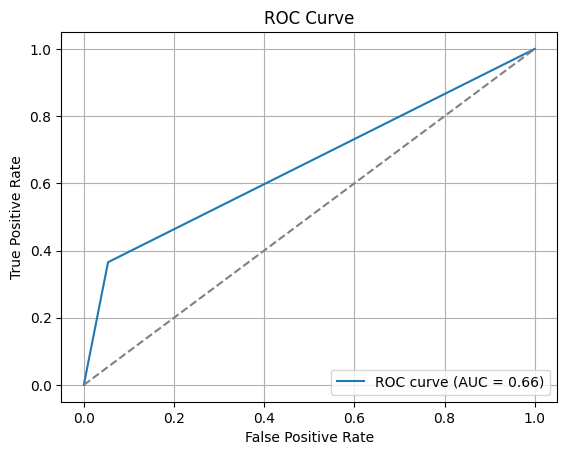

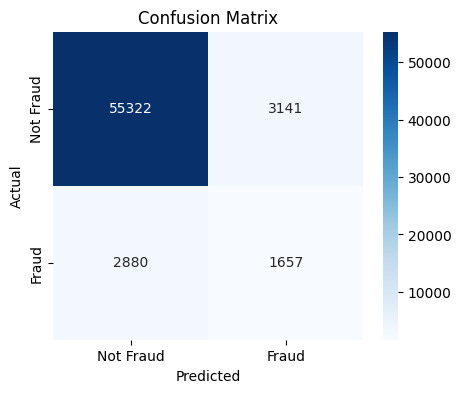

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     58463
           1       0.35      0.37      0.36      4537

    accuracy                           0.90     63000
   macro avg       0.65      0.66      0.65     63000
weighted avg       0.91      0.90      0.91     63000

AUC: 0.6557465097454904, Recall: 0.3652193079127177


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('time_features',
                                                  TimeTransformer(),
                                                  ['Transaction.Date',
                                                   'Transaction.Hour']),
                                                 ('high_amount',
                                                  HighAmountTransformer(),
                                                  ['Transaction.Amount']),
                                                 ('numerical', StandardScaler(),
                                                  ['Transaction.Amount',
                                                   'Customer.Age',
                                                   'Account.Age.Days',
                                                   'Quantity']),
                                                 ('age', AgeTransfomer(),
                                                  ['Customer.Age']),
                                                 ('sex',...
                                                 ('catBasic',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['Payment.Method', 'browser',
                                                   'Product.Category',
                                                   'Device.Used',
                                                   'source'])])),
                ('featureselection',
                 RFE(estimator=LogisticRegression(C=0.1,
                                                  class_weight='balanced',
                                                  penalty='l1', random_state=42,
                                                  solver='liblinear'),
                     n_features_to_select=30)),
                ('model', KNeighborsClassifier(n_jobs=-1, n_neighbors=1))])

In [7]:
TestingModel("KNN",X_train,X_test,y_train,y_test,threshold=0.5)

### Regresja logistyczna - zdecydowanie za dużo fałszywych wykryć

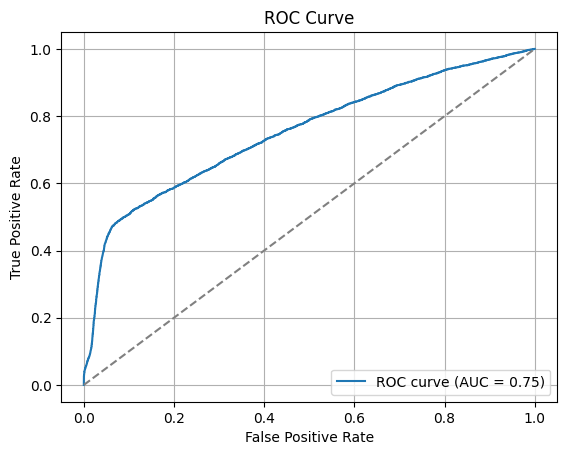

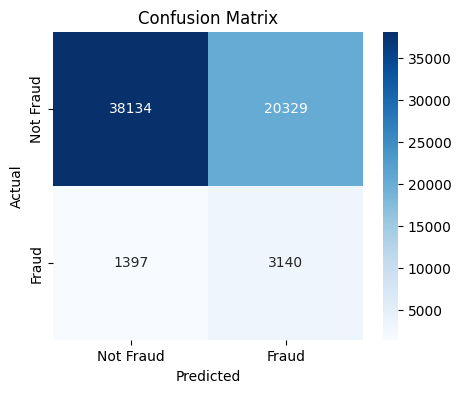

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.65      0.78     58463
           1       0.13      0.69      0.22      4537

    accuracy                           0.66     63000
   macro avg       0.55      0.67      0.50     63000
weighted avg       0.90      0.66      0.74     63000

AUC: 0.7510016856726824, Recall: 0.692087282345162


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('time_features',
                                                  TimeTransformer(),
                                                  ['Transaction.Date',
                                                   'Transaction.Hour']),
                                                 ('high_amount',
                                                  HighAmountTransformer(),
                                                  ['Transaction.Amount']),
                                                 ('numerical', StandardScaler(),
                                                  ['Transaction.Amount',
                                                   'Customer.Age',
                                                   'Account.Age.Days',
                                                   'Quantity']),
                                                 ('age', AgeTransfomer(),
                                                  ['Customer.Age']),
                                                 ('sex',...
                                                                handle_unknown='ignore'),
                                                  ['Payment.Method', 'browser',
                                                   'Product.Category',
                                                   'Device.Used',
                                                   'source'])])),
                ('featureselection',
                 RFE(estimator=LogisticRegression(C=0.1,
                                                  class_weight='balanced',
                                                  penalty='l1', random_state=42,
                                                  solver='liblinear'),
                     n_features_to_select=30)),
                ('model',
                 LogisticRegression(C=0.005, class_weight='balanced', n_jobs=-1,
                                    random_state=42, solver='saga'))])

In [8]:
TestingModel("LogisticRegression",X_train,X_test,y_train,y_test,threshold=0.5)

### Drzewa decyzyjne - całkiem spoko

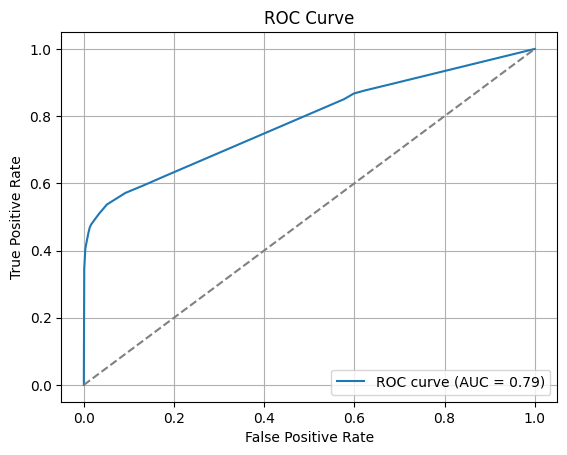

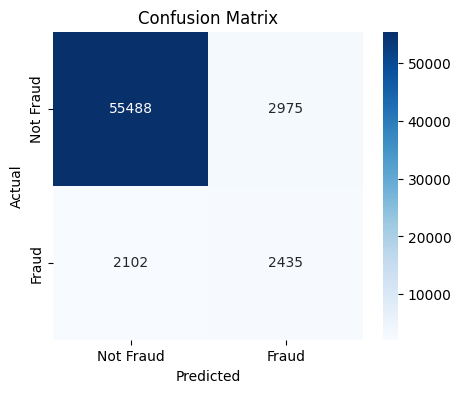

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96     58463
           1       0.45      0.54      0.49      4537

    accuracy                           0.92     63000
   macro avg       0.71      0.74      0.72     63000
weighted avg       0.93      0.92      0.92     63000

AUC: 0.7853460615678847, Recall: 0.5366982587612961


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('time_features',
                                                  TimeTransformer(),
                                                  ['Transaction.Date',
                                                   'Transaction.Hour']),
                                                 ('high_amount',
                                                  HighAmountTransformer(),
                                                  ['Transaction.Amount']),
                                                 ('numerical', StandardScaler(),
                                                  ['Transaction.Amount',
                                                   'Customer.Age',
                                                   'Account.Age.Days',
                                                   'Quantity']),
                                                 ('age', AgeTransfomer(),
                                                  ['Customer.Age']),
                                                 ('sex',...
                                                  ['Payment.Method', 'browser',
                                                   'Product.Category',
                                                   'Device.Used',
                                                   'source'])])),
                ('featureselection',
                 RFE(estimator=LogisticRegression(C=0.1,
                                                  class_weight='balanced',
                                                  penalty='l1', random_state=42,
                                                  solver='liblinear'),
                     n_features_to_select=30)),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=8,
                                        max_features=0.65, max_leaf_nodes=20,
                                        random_state=42))])

In [9]:
TestingModel("DecisionTree",X_train,X_test,y_train,y_test,threshold=0.5)

### Naive Bayes - zbyt dużo fałszywych wykryć, mimo całkiem dobrego recall

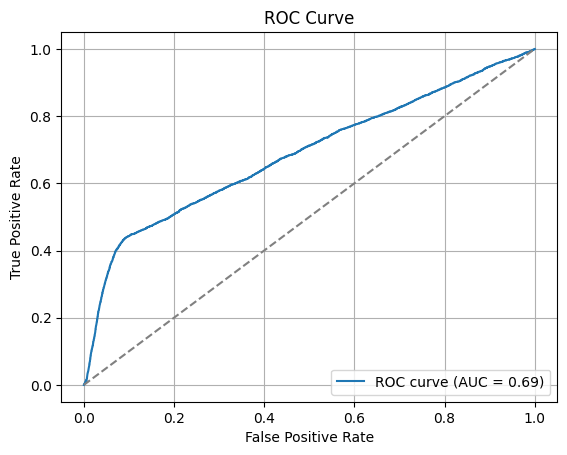

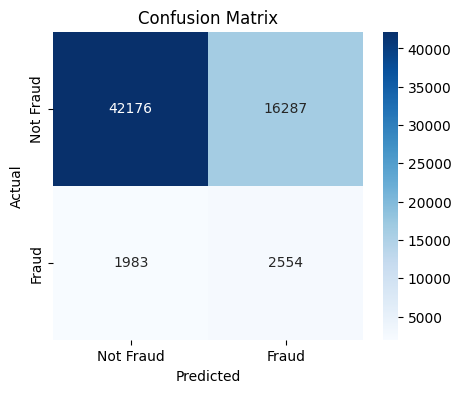

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.72      0.82     58463
           1       0.14      0.56      0.22      4537

    accuracy                           0.71     63000
   macro avg       0.55      0.64      0.52     63000
weighted avg       0.90      0.71      0.78     63000

AUC: 0.6872107793142903, Recall: 0.5629270443024025


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('time_features',
                                                  TimeTransformer(is_NB=True),
                                                  ['Transaction.Date',
                                                   'Transaction.Hour']),
                                                 ('high_amount',
                                                  HighAmountTransformer(),
                                                  ['Transaction.Amount']),
                                                 ('numerical', MinMaxScaler(),
                                                  ['Transaction.Amount',
                                                   'Customer.Age',
                                                   'Account.Age.Days',
                                                   'Quantity']),
                                                 ('age', AgeTransfomer(),
                                                  ['Customer.Age'])...
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['Payment.Method', 'browser',
                                                   'Product.Category',
                                                   'Device.Used',
                                                   'source'])])),
                ('featureselection',
                 RFE(estimator=LogisticRegression(C=0.1,
                                                  class_weight='balanced',
                                                  penalty='l1', random_state=42,
                                                  solver='liblinear'),
                     n_features_to_select=30)),
                ('model',
                 CategoricalNB(alpha=20, fit_prior=False, min_categories=2))])

In [10]:
TestingModel("CategoricalNB",X_train,X_test,y_train,y_test,threshold=0.5)

### SVM - to jakiś żart? Skip

d:\Anaconda\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


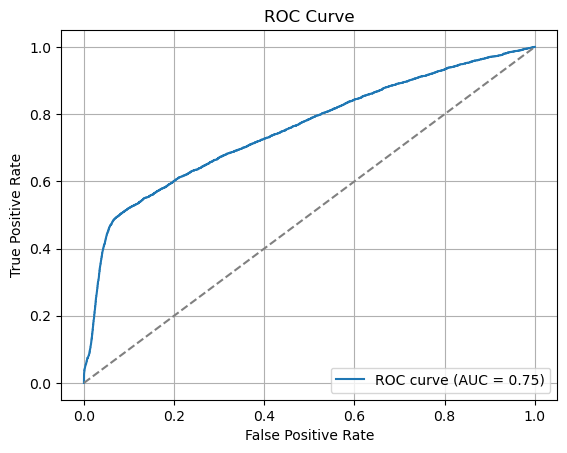

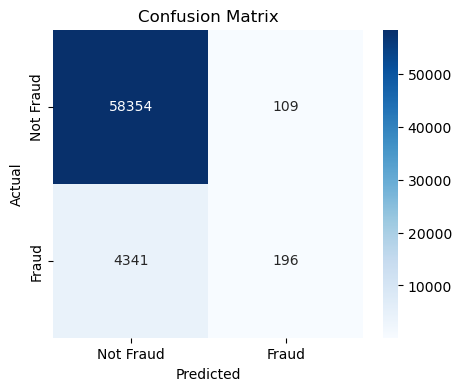

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96     58463
           1       0.64      0.04      0.08      4537

    accuracy                           0.93     63000
   macro avg       0.79      0.52      0.52     63000
weighted avg       0.91      0.93      0.90     63000

AUC: 0.7541515390632803, Recall: 0.04320035265594005


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('time_features',
                                                  TimeTransformer(),
                                                  ['Transaction.Date',
                                                   'Transaction.Hour']),
                                                 ('high_amount',
                                                  HighAmountTransformer(),
                                                  ['Transaction.Amount']),
                                                 ('numerical', StandardScaler(),
                                                  ['Transaction.Amount',
                                                   'Customer.Age',
                                                   'Account.Age.Days',
                                                   'Quantity']),
                                                 ('age', AgeTransfomer(),
                                                  ['Customer.Age']),
                                                 ('sex',...
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['Payment.Method', 'browser',
                                                   'Product.Category',
                                                   'Device.Used',
                                                   'source'])])),
                ('featureselection',
                 RFE(estimator=LogisticRegression(C=0.1,
                                                  class_weight='balanced',
                                                  penalty='l1', random_state=42,
                                                  solver='liblinear'),
                     n_features_to_select=30)),
                ('model',
                 LinearSVC(C=1e-05, class_weight='balanced', random_state=42,
                           tol=0.001))])

In [11]:
TestingModel("SVM",X_train,X_test,y_train,y_test,threshold=0.5)

### Random Forest - obiecująco

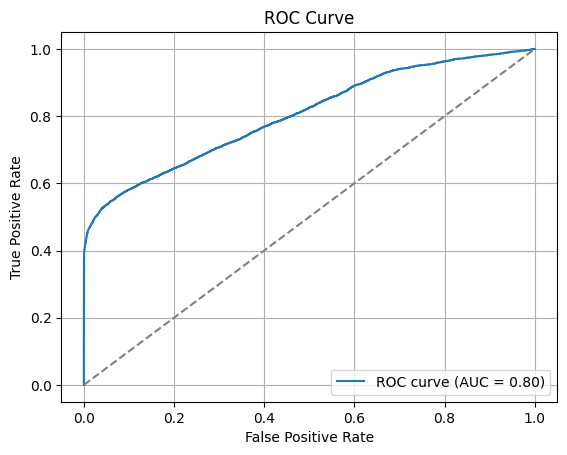

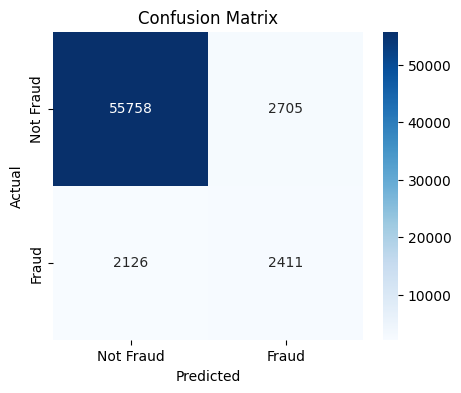

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96     58463
           1       0.47      0.53      0.50      4537

    accuracy                           0.92     63000
   macro avg       0.72      0.74      0.73     63000
weighted avg       0.93      0.92      0.93     63000

AUC: 0.8033629124586317, Recall: 0.5314084196605686


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('time_features',
                                                  TimeTransformer(),
                                                  ['Transaction.Date',
                                                   'Transaction.Hour']),
                                                 ('high_amount',
                                                  HighAmountTransformer(),
                                                  ['Transaction.Amount']),
                                                 ('numerical', StandardScaler(),
                                                  ['Transaction.Amount',
                                                   'Customer.Age',
                                                   'Account.Age.Days',
                                                   'Quantity']),
                                                 ('age', AgeTransfomer(),
                                                  ['Customer.Age']),
                                                 ('sex',...
                                                   'Product.Category',
                                                   'Device.Used',
                                                   'source'])])),
                ('featureselection',
                 RFE(estimator=LogisticRegression(C=0.1,
                                                  class_weight='balanced',
                                                  penalty='l1', random_state=42,
                                                  solver='liblinear'),
                     n_features_to_select=30)),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=8,
                                        max_features=0.5, min_samples_leaf=10,
                                        min_samples_split=5, n_estimators=200,
                                        random_state=42))])

In [11]:
TestingModel("RandomForest",X_train,X_test,y_train,y_test,threshold=0.5)

# Wnioski z prostych modeli
Najlepiej poradziły sobie modele drzewowe - DecisionTree oraz RandomForest. Gwarantują one przyzwoity recall, jednocześnie nie wykrywając przesadnie dużo w w rzeczywistości fałszywych oszustw.